In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('drive/My Drive')

In [5]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !unzip archive.zip

In [ ]:
import pandas as pd
emails = pd.read_csv('emails.csv')

In [ ]:
emails.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [ ]:
emails['message'][1]

"Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>\nDate: Fri, 4 May 2001 13:51:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: john.lavorato@enron.com\nSubject: Re:\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nTraveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what 

In [ ]:
import email
def parse_func(x):
  b = email.message_from_string(x)
  body = ''
  if b.is_multipart():
    for payload in b.get_payload():
      body = body+ ' '
      body+=payload.get_payload()
  else:
    body+=b.get_payload()

  return body

In [ ]:
def parse_func_subj(x):
  b = email.message_from_string(x)
  if b.get('Subject'):
    subj = b.get('Subject')
  else:
    subj = '-'
  return subj

In [ ]:
emails['Body'] = emails['message'].apply(parse_func)
emails['Subject'] = emails['message'].apply(parse_func_subj)

In [ ]:
emails.tail()

,file,message,Body,Subject
517396,zufferli-j/sent_items/95.,Message-ID: <26807948.1075842029936.JavaMail.e...,This is a trade with OIL-SPEC-HEDGE-NG (John L...,Trade with John Lavorato
517397,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...,Some of my position is with the Alberta Term b...,Gas Hedges
517398,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...,2\n\n -----Original Message-----\nFrom: \tDouc...,RE: CONFIDENTIAL
517399,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...,Calgary Analyst/Associate
517400,zufferli-j/sent_items/99.,Message-ID: <28618979.1075842030037.JavaMail.e...,i think the YMCA has a class that is for peopl...,RE: ali's essays


In [ ]:
def decontractions(phrase):
  """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""

  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"won\’t", "will not", phrase)
  phrase = re.sub(r"can\’t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)

  phrase = re.sub(r"n\’t", " not", phrase)
  phrase = re.sub(r"\’re", " are", phrase)
  phrase = re.sub(r"\’s", " is", phrase)
  phrase = re.sub(r"\’d", " would", phrase)
  phrase = re.sub(r"\’ll", " will", phrase)
  phrase = re.sub(r"\’t", " not", phrase)
  phrase = re.sub(r"\’ve", " have", phrase)
  phrase = re.sub(r"\’m", " am", phrase)

  return phrase

In [ ]:
'''Take the raw email body as input and clean the unnecessary text like \n,\t etc and also keep only alphabets and full stop(.)(for sentence separation)
and replace extra spaces with one space and return clean text'''

import re
body = []
for text in emails['Body']:
  text = decontractions(text)
  text = re.sub(r"\n|\t", ' ', text)
  text = re.sub("[^a-zA-Z\s.]+",' ',text)
  text = re.sub("\s+", ' ', text)
  body.append(text)
emails['Processed_Text'] = body


In [ ]:
'''Clean the subject of the mail by following the same steps as cleaning the email body including removing 're:' '''

body = []
for text in emails['Subject']:
  text = text.lower()
  text = re.sub('re:','',text)
  text = decontractions(text)
  text = re.sub(r"\n|\t", ' ', text)
  text = re.sub("[^a-zA-Z\s.]+",' ',text)
  text = re.sub("\s+", ' ', text)
  body.append(text.strip())
emails['Processed_Subject'] = body
emails

,file,message,Body,Subject,Processed_Text,Processed_Subject
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,-,Here is our forecast,
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,Re:,Traveling to have a business meeting takes the...,
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,Re: test,test successful. way to go,test
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...",-,Randy Can you send me a schedule of the salary...,
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,Re: Hello,Let is shoot for Tuesday at .,hello
...,...,...,...,...,...,...
517396,zufferli-j/sent_items/95.,Message-ID: <26807948.1075842029936.JavaMail.e...,This is a trade with OIL-SPEC-HEDGE-NG (John L...,Trade with John Lavorato,This is a trade with OIL SPEC HEDGE NG John La...,trade with john lavorato
517397,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...,Some of my position is with the Alberta Term b...,Gas Hedges,Some of my position is with the Alberta Term b...,gas hedges
517398,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...,2\n\n -----Original Message-----\nFrom: \tDouc...,RE: CONFIDENTIAL,Original Message From Doucet Dawn Sent Wednes...,confidential
517399,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...,Calgary Analyst/Associate,Analyst Rank Stephane Brodeur Chad Clark Ian C...,calgary analyst associate


In [ ]:
import matplotlib.pyplot as plt
char_lengths = pd.Series([len(str(x)) for x in emails['Processed_Text']])

char_lengths.describe()

count    3.447290e+05
mean     1.413327e+03
std      8.441524e+03
min      1.000000e+00
25%      1.650000e+02
50%      4.220000e+02
75%      1.099000e+03
max      1.984612e+06
dtype: float64

We took the character lengths from each email and the stats are as follows.

-Minimum value is 0 which means after cleaning some mails have 0 characters. We can remove them from our data as they wont be of any use. 
-Maximum value is 18 lakhs which is definitely an outlier. It might be mistakenly entered into the data or some particular mails might be lengthy. 
-We understood the above are outliers from the 75th percentile of data. Lenght is 1.5k which is normal length. 

To analyse further we shall see the sentence lengths and word lenghts of emails.

In [ ]:
sentences = pd.Series([len(str(x).split('.')) for x in emails['Processed_Text']])
sentences.describe()

count    344729.000000
mean         19.256906
std          74.460999
min           1.000000
25%           3.000000
50%           7.000000
75%          14.000000
max       10520.000000
dtype: float64

In [ ]:
emails['no_of_sent'] = sentences
emails[emails['no_of_sent']>40]

,file,message,Body,Subject,Processed_Text,Processed_Subject,no_of_sent
323,allen-p/_sent_mail/557.,Message-ID: <16004214.1075855728430.JavaMail.e...,By STEVE EVERLY - The Kansas City Star\nDate: ...,-,By STEVE EVERLY The Kansas City Star Date As n...,,84
392,allen-p/all_documents/1.,Message-ID: <29790972.1075855665306.JavaMail.e...,In today's Daily Update you'll find free repor...,"December 14, 2000 - Bear Stearns' predictions ...",In today is Daily Update you will find free re...,december bear stearns predictions for telecom ...,135
393,allen-p/all_documents/10.,Message-ID: <21975671.1075855665520.JavaMail.e...,Here is today's copy of Bloomberg Power Lines....,Bloomberg Power Lines Report,Here is today is copy of Bloomberg Power Lines...,bloomberg power lines report,385
456,allen-p/all_documents/19.,Message-ID: <29399491.1075855665902.JavaMail.e...,"Y-Life Daily Bulletin: December 13, 2000\n\nNo...",Y-Life Daily: Bush will almost definitely be p...,Y Life Daily Bulletin December Note If your e ...,y life daily bush will almost definitely be pr...,124
463,allen-p/all_documents/2.,Message-ID: <31189653.1075855665329.JavaMail.e...,"As requested, here is the December Autoweb.com...",December Newsletter - Factory Incentives are a...,As requested here is the December Autoweb.com ...,december newsletter factory incentives are at ...,68
...,...,...,...,...,...,...,...
344556,zufferli-j/deleted_items/82.,Message-ID: <2065626.1075842023405.JavaMail.ev...,"<html><head></head>\n<body bgcolor=""#ffffff""><...",Extended Websaver continues through January,html head head body bgcolor ffffff font color...,extended websaver continues through january,258
344561,zufferli-j/deleted_items/9.,Message-ID: <3341011.1075842020660.JavaMail.ev...,\n[IMAGE]=09\n\n\n[IMAGE] [IMAGE][IMAGE][IMAGE...,"Syncrasy Daily Trader Summary for Wed, Feb 06,...",IMAGE IMAGE IMAGE IMAGE IMAGE IMAGE IMAGE IMA...,syncrasy daily trader summary for wed feb,134
344564,zufferli-j/deleted_items/92.,Message-ID: <11314126.1075842023658.JavaMail.e...,\n[IMAGE]=09\n\n\n[IMAGE] [IMAGE][IMAGE][IMAGE...,"Syncrasy Daily Trader Summary for Tue, Jan 29,...",IMAGE IMAGE IMAGE IMAGE IMAGE IMAGE IMAGE IMA...,syncrasy daily trader summary for tue jan,142
344565,zufferli-j/deleted_items/93.,Message-ID: <3550151.1075842023814.JavaMail.ev...,\n\nTransmission Expansion and Systems in Tran...,Upcoming Conferences,Transmission Expansion and Systems in Transit...,upcoming conferences,43


Median sentence length is 9 sentences per email. As we saw above, there are outliers. Since our task is sentence completion, we can extract sentences from emails to create each sentence as a data point. After analysing the emails with high number of sentences, we found that mail is having multiple mails in a mail chain. So we need to see how to separate out the text from the data. Also we need to remove parts like Forwarded by, To, Cc, From etc from the text that have many sentences.

#Data Preparation

In some rows, there are mails that were forwarded by so we remove such emails as we want clean data.

In [ ]:
'''To remove emails that has the words Original Message or Forwarded by'''
remove=[]
for i in emails.index:
  text = emails.loc[i]['Body']
  if ('Original Message' in text) or ('Forwarded by' in text):
    remove.append(i)

emails.drop(remove,axis=0,inplace=True)
emails.reset_index(drop=True,inplace=True)
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344729 entries, 0 to 344728
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   file               344729 non-null  object
 1   message            344729 non-null  object
 2   Body               344729 non-null  object
 3   Subject            344729 non-null  object
 4   Processed_Text     344729 non-null  object
 5   Processed_Subject  344729 non-null  object
dtypes: object(6)
memory usage: 15.8+ MB


In [ ]:
emails_original = emails

##Short sentences

Since there are many emails that have large number of sentences because there are mail chains present in the mails. Also in those chains there is a lot of unwanted text which won't be of any use for us. So we here take emails that have less than 10 sentences for our task. 

In [ ]:
'''Take mails that have less than 10 sentences'''
emails = emails_original[emails_original['no_of_sent']<10]
emails.reset_index(drop=True,inplace=True)
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216479 entries, 0 to 216478
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   file               216479 non-null  object
 1   message            216479 non-null  object
 2   Body               216479 non-null  object
 3   Subject            216479 non-null  object
 4   Processed_Text     216479 non-null  object
 5   Processed_Subject  216479 non-null  object
 6   no_of_sent         216479 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


In [ ]:
'''Take sentences which have word length in range 5 and 12, split the sentence at each word to prepare inputs and outputs. 
To inputs add subject of the mail'''

input = []
output = []
for i in emails.index:
  subject = emails.loc[i]['Processed_Subject']
  sentences = emails.loc[i]['Processed_Text'].split('.')
  for sent in sentences:
    sent = sent.lower()
    noof_words = len(sent.split())
    if noof_words in range(5,13):
      # half = int(noof_words/2)
      words = sent.split()
      for i in range(3,noof_words):
        if i%3==0:
          if noof_words-i>=4:
            input.append(' '.join(subject.split()[:5]+words[:i]))
            output.append(' '.join(words[i:i+4]))
        elif i%3==1:
          if noof_words-i>=3:
            input.append(' '.join(subject.split()[:5]+words[:i]))
            output.append(' '.join(words[i:i+3]))
        else:
          if noof_words-i>=2:
            input.append(' '.join(subject.split()[:5]+words[:i]))
            output.append(' '.join(words[i:i+2]))



In [ ]:
data_short = pd.DataFrame(columns=['input','output'])
data_short['input']=input
data_short['output']=output
data_short.head()

,input,output
0,plus your thoughts,on any changes that
1,plus your thoughts on,any changes that
2,plus your thoughts on any,changes that
3,plus your thoughts on any changes,that need to be
4,plus your thoughts on any changes that,need to be


##Longer sentences

In [ ]:
emails = emails_original[emails_original['no_of_sent']<10]
emails.reset_index(drop=True,inplace=True)
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216479 entries, 0 to 216478
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   file               216479 non-null  object
 1   message            216479 non-null  object
 2   Body               216479 non-null  object
 3   Subject            216479 non-null  object
 4   Processed_Text     216479 non-null  object
 5   Processed_Subject  216479 non-null  object
 6   no_of_sent         216479 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


In [ ]:
'''Take sentences which have word length in range 10 and 14, split the sentence at each word to prepare inputs and outputs. 
To inputs add subject of the mail'''

import random
input = []
output = []
for i in emails.index:
  subject = emails.loc[i]['Processed_Subject']
  sentences = emails.loc[i]['Processed_Text'].split('.')
  for sent in sentences:
    sent = sent.lower()
    noof_words = len(sent.split())
    if noof_words in range(10,15):
      # half = int(noof_words/2)
      words = sent.split()
      for i in range(10,noof_words):
        rn = random.randint(3,6)
        if noof_words-i>=rn:
          input.append(' '.join(subject.split()[:5]+words[:i]))
          output.append(' '.join(words[i:i+rn]))
 

In [ ]:
data_long = pd.DataFrame(columns=['input','output'])
data_long['input']=input
data_long['output']=output
data_long.head(5)

,input,output
0,com monique sanchez frank ermis john lavorato ...,your help phillip allen
1,john denver is short rockies position beyond i...,their trailblazer transport
2,burnet i would also like to review the closing...,soon as possible
3,western gas market report draft richard compar...,california gas report
4,cooper can you give access to the new west power,site to jay


##Word breaking

In [ ]:
emails = emails_original[emails_original['no_of_sent']<10]
emails.reset_index(drop=True,inplace=True)
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216479 entries, 0 to 216478
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   file               216479 non-null  object
 1   message            216479 non-null  object
 2   Body               216479 non-null  object
 3   Subject            216479 non-null  object
 4   Processed_Text     216479 non-null  object
 5   Processed_Subject  216479 non-null  object
 6   no_of_sent         216479 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


In [ ]:
'''Take sentences which have word length in range 5 and 12, split the sentence at each word by splitting the word into halves
 by putting first half in input and other half in output. To inputs add subject of the mail'''

input = []
output = []
for i in emails.index:
  subject = emails.loc[i]['Processed_Subject']
  sentences = emails.loc[i]['Processed_Text'].split('.')
  for sent in sentences:
    sent = sent.lower()
    noof_words = len(sent.split())
    if noof_words in range(5,13):
      # half = int(noof_words/2)
      words = sent.split()
      for i in range(3,noof_words):
        if len(words[i])>=5 and noof_words-i>=3:
          for j in range(3,len(words[i])):
            if len(words[i])-j>=2:
              half_word_1 = words[i][:j]
              half_word_2 = words[i][j:]
              input.append(' '.join(subject.split()[:5]+words[:i-1]+[half_word_1]))
              output.append(' '.join([half_word_2]+words[i+1:i+3]))
 

In [ ]:
data_wordbrk = pd.DataFrame(columns=['input','output'])
data_wordbrk['input']=input
data_wordbrk['output']=output
data_wordbrk.head()

,input,output
0,plus your thoughts on cha,nges that need
1,plus your thoughts on chan,ges that need
2,plus your thoughts on chang,es that need
3,hello greg how eit,her next tuesday
4,hello greg how eith,er next tuesday


##Append all data

In [ ]:
final_data = pd.concat([data_short, data_long, data_wordbrk])
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2218723 entries, 0 to 1230803
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   input   object
 1   output  object
dtypes: object(2)
memory usage: 50.8+ MB


Since there is a possibility of duplicate items, we checked for the same and found there are many. So we remove the duplicate items from our data. 

In [ ]:
final_data = final_data.drop_duplicates(ignore_index=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781268 entries, 0 to 781267
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   input   781268 non-null  object
 1   output  781268 non-null  object
dtypes: object(2)
memory usage: 11.9+ MB


In [ ]:
# new_data.to_excel('cs2_long_sent.xlsx',index=False)

After preparing the data in required formats and appending the data and removing the duplicates, we got around 6lakh data points on which we will be training next word(s) prediction model.

#Final Model

In [ ]:
new_data = final_data
new_data.head()

,input,output
0,plus your thoughts,on any changes that
1,plus your thoughts on,any changes that
2,plus your thoughts on any,changes that
3,plus your thoughts on any changes,that need to be
4,plus your thoughts on any changes that,need to be


In [ ]:
# import pickle
# outfile = open('final_data_cs2_subject.pkl','wb')
# pickle.dump(new_data,outfile)
# outfile.close()

In [ ]:
import pickle
infile = open('final_data_cs2_subject.pkl','rb')
new_data = pickle.load(infile)
infile.close()

In [ ]:
'''Prepare the data in a format according to Encoder Decoder model'''

new_data['decoder_input'] = '<start> ' + new_data['output'].astype(str)
new_data['decoder_output'] = new_data['output'].astype(str) + ' <end>'
new_data = new_data.drop(['output'], axis=1)
new_data.head()

,input,decoder_input,decoder_output
0,plus your thoughts,<start> on any changes that,on any changes that <end>
1,plus your thoughts on,<start> any changes that,any changes that <end>
2,plus your thoughts on any,<start> changes that,changes that <end>
3,plus your thoughts on any changes,<start> that need to be,that need to be <end>
4,plus your thoughts on any changes that,<start> need to be,need to be <end>


In [ ]:
max_len_enc = max([len(x.split()) for x in new_data.input])
max_len_dec = max([len(x.split()) for x in new_data.decoder_input])

In [ ]:
max_len_enc, max_len_dec

(16, 5)

We don't split the data into train and test because all the data we have should be put to use to generate better predictions

In [ ]:
'''Tokenize the encoder's vocab and decoder vocab.
In decoder's tokenizer, we have to filter some characters to include <start>, <end> as unique tokens'''

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_encoder = Tokenizer(oov_token='out_of_vocab')
tokenizer_encoder.fit_on_texts(new_data['input'].values)

tokenizer_decoder = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_decoder.fit_on_texts(np.append(new_data['decoder_input'].values,'<end>')) #to add <end> in the corpus

vocab_size_enc = len(tokenizer_encoder.word_index)+1
vocab_size_dec = len(tokenizer_decoder.word_index)+1

print("Vocab sizes of encoder and decoder are ",vocab_size_enc,vocab_size_dec)


Vocab sizes of encoder and decoder are  44893 34335


In [ ]:
tokenizer_decoder.word_index['<end>']

34334

In [ ]:
import pickle
outfile = open('tokenizers_subject.pkl','wb')
pickle.dump((tokenizer_encoder,tokenizer_decoder),outfile)
outfile.close()

In [ ]:
'''change the sentences to tokens and then pad them to maximum length such that all inputs and outputs'''

tokenzd_seq_enc = tokenizer_encoder.texts_to_sequences(new_data['input'].values)
tokenzd_seq_dec_ip = tokenizer_decoder.texts_to_sequences(new_data['decoder_input'].values)
tokenzd_seq_dec_op = tokenizer_decoder.texts_to_sequences(new_data['decoder_output'].values)

enc_padded = pad_sequences(tokenzd_seq_enc, maxlen=max_len_enc, dtype='int32', padding='post')
dec_ip_padded = pad_sequences(tokenzd_seq_dec_ip, maxlen=max_len_dec, dtype='int32', padding='post')
dec_op_padded = pad_sequences(tokenzd_seq_dec_op, maxlen=max_len_dec, dtype='int32', padding='post')

print(enc_padded.shape,dec_ip_padded.shape,dec_op_padded.shape)

(781268, 16) (781268, 5) (781268, 5)


In [ ]:
'''convert our data into tf.data format for easy and fast loading of batches'''

BATCH_SIZE=1024
train_dataset = tf.data.Dataset.from_tensor_slices(((enc_padded, dec_ip_padded),dec_op_padded))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
'''Load pre trained word embeddings to encoder and decoder's embedding layers'''

embeddings_index = dict()
f = open('Translation/glove.6B.300d.txt')
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
embedding_matrix_enc = np.random.normal(size=(vocab_size_enc, 300))
for word, i in tokenizer_encoder.word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
  embedding_matrix_enc[i] = embedding_vector


In [ ]:
embeddings_index = dict()
f = open('Translation/glove.6B.300d.txt')
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
embedding_matrix_dec = np.random.normal(size=(vocab_size_dec, 300))
for word, i in tokenizer_decoder.word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
  embedding_matrix_dec[i] = embedding_vector

In [ ]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        
        '''Initialize the embedding and LSTM layers that will be used in our encoder layer'''
        
        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                    mask_zero=True, name="embedding_layer_encoder", weights=[embedding_matrix_enc], trainable=True)
        # self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
        #                            mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0


    def call(self,input_sequence): 
        
        '''
        Takes encoder's input sequence and return encoder's lstm's output
        '''
        
        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    

In [ ]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        
        '''Initialize the embedding and LSTM layers that will be used in our decoder layer'''
        
        super().__init__()
        # self.embedding = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, input_length=input_length,
        #                    mask_zero=True, name="embedding_layer_decoder")
        self.embedding = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True, name="embedding_layer_decoder", weights=[embedding_matrix_dec], trainable=True)
        self.lstm = LSTM(lstm_size, return_sequences=True, return_state=True, name="Decoder_LSTM")
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        


    def call(self,input_sequence,initial_states):
        
        '''
        Takes decoder's input for teacher forcing, encoder's final states as initial states for decoder's lstm and return decoder lstm's output
        '''

        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd, initial_state=initial_states)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c



In [ ]:
'''Create a functional model with the custom layers built above and train it with our data'''

embed_dim = 300
enc_input_length = max_len_enc
dec_input_length = max_len_dec
lstm_units = 512

X_input1 = Input(shape=(max_len_enc,))
X_input2 = Input(shape=(max_len_dec,))
X_input3 = Input(shape=(max_len_dec,))

encoder_output, encoder_h, encoder_c = Encoder(inp_vocab_size=vocab_size_enc, embedding_size=embed_dim,input_length=enc_input_length, lstm_size = lstm_units)(X_input1)
decoder_output,_,_ = Decoder(out_vocab_size=vocab_size_dec, embedding_size=embed_dim,input_length=dec_input_length, lstm_size = lstm_units)(X_input2,initial_states=(encoder_h, encoder_c))
output = Dense(vocab_size_dec, activation='softmax')(decoder_output)

model = Model(inputs = [[X_input1,X_input2],X_input3], outputs = output)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=new_data.shape[0]//BATCH_SIZE
history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=30)


Epoch 1/30
762/762 [==============================] - 366s 466ms/step - loss: 4.5500
Epoch 2/30
762/762 [==============================] - 367s 482ms/step - loss: 3.4868
Epoch 3/30
762/762 [==============================] - 366s 481ms/step - loss: 2.9852
Epoch 4/30
762/762 [==============================] - 365s 479ms/step - loss: 2.6535
Epoch 5/30
762/762 [==============================] - 365s 479ms/step - loss: 2.3940
Epoch 6/30
762/762 [==============================] - 364s 478ms/step - loss: 2.1723
Epoch 7/30
762/762 [==============================] - 365s 479ms/step - loss: 1.9810
Epoch 8/30
762/762 [==============================] - 364s 478ms/step - loss: 1.8162
Epoch 9/30
762/762 [==============================] - 365s 479ms/step - loss: 1.6700
Epoch 10/30
762/762 [==============================] - 364s 478ms/step - loss: 1.5399
Epoch 11/30
762/762 [==============================] - 364s 478ms/step - loss: 1.4221
Epoch 12/30
762/762 [==============================] - 364s 478

In [ ]:
history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=5)

Epoch 1/5
762/762 [==============================] - 359s 471ms/step - loss: 0.2551
Epoch 2/5
762/762 [==============================] - 366s 480ms/step - loss: 0.2408
Epoch 3/5
762/762 [==============================] - 366s 481ms/step - loss: 0.2275
Epoch 4/5
762/762 [==============================] - 367s 482ms/step - loss: 0.2146
Epoch 5/5
762/762 [==============================] - 366s 481ms/step - loss: 0.2072


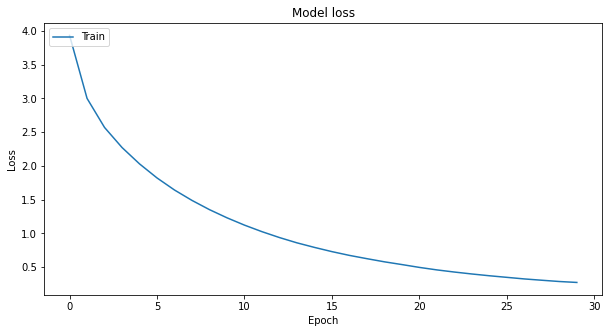

In [ ]:
# Plot training & validation iou_score values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
model.save('final_enc_dec_wthsubj_upd')

INFO:tensorflow:Assets written to: final_enc_dec_wthsubj_upd/assets


INFO:tensorflow:Assets written to: final_enc_dec_wthsubj_upd/assets


In [ ]:
loaded_model = tf.keras.models.load_model('final_enc_dec_wthsubj_upd')

In [ ]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
encoder (Encoder)               ((None, 16, 512), (N 15132924    input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Decoder)               ((None, 5, 512), (No 11965524    input_2[0][0]                    
                                                                 encoder[0][1]                

In [ ]:
def predict(input_sentence,model):

  '''
  Given an input sentence, we need to predict the next words.
  Tokenize and pad the input sentence,
  Pass it to encoder's embedding layer and its output to encoder's LSTM layer.
  Pass its final states hidden and cell states as inputs to decoder's LSTM
  Before that, initialize <start> word and pass it to decoders embedding layer and then to LSTM layer,
  We run a loop till we get <end> word.
  We give predicted word at decoder's current step as input to its next step.
  '''
  
  encoder_test_tokens = tokenizer_encoder.texts_to_sequences([input_sentence])
  padded_encoder_input = pad_sequences(encoder_test_tokens, maxlen=16, dtype='float32', padding='post')
  encoder = model.layers[2]
  encoder_op, enc_h, enc_c = encoder(padded_encoder_input)
  decoder = model.layers[3]
  index_of_start = np.array(tokenizer_decoder.word_index['<start>']).reshape(1,1)
  states=(enc_h, enc_c)
  dense = model.layers[5]
  pred=0
  sentence = []
  while pred!=tokenizer_decoder.word_index['<end>']:
    dec_emb= decoder.embedding(index_of_start)
    predicted_out,state_h,state_c=decoder.lstm(dec_emb,states)
    pred = np.argmax(dense(predicted_out))
    word = [k for k in tokenizer_decoder.word_index if tokenizer_decoder.word_index[k]==pred][0]
    sentence.append(word)
    states= (state_h, state_c)
    index_of_start = np.array(pred).reshape(1,1)
  return ' '.join(sentence[:-1])

Now we will separate out sentences where predictions are bad and analyse them

In [ ]:
import numpy as np
sample = new_data.sample(100000,random_state=42)
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
incorrect_predictions=[]
for i in tqdm(sample.index):
  predicted = predict(new_data.loc[i]['input'],loaded_model)
  predicted_sent = predicted.split()
  original = [x for x in new_data.loc[i]['decoder_input'].split() if x!='<start>']
  if bleu.sentence_bleu([original],predicted_sent)<0.2:
    incorrect_predictions.append((new_data.loc[i]['input'],' '.join(original),predicted))


100%|██████████| 100000/100000 [1:46:14<00:00, 15.69it/s]


In [ ]:
# import pickle
# outfile = open('incorrect_preds.pkl','wb')
# pickle.dump(incorrect_predictions,outfile)
# outfile.close()

In [ ]:
import pickle
infile = open('incorrect_preds.pkl','rb')
incorrect_predictions = pickle.load(infile)
infile.close()

In [ ]:
for i in range(len(incorrect_predictions[:20])):
  print(incorrect_predictions[i][0],"_",incorrect_predictions[i][1],'_',incorrect_predictions[i][2])

price processes for ng i should examine other contracts behavior beyond prompt _ month as _ ly worse the
did i call it or i am looking _ damn good at bux _ forward to
stca forward ob position the stca desk will be _ short mw _ under on peak
ene friday report please open as read only _ and do _ thing good
martin gas sales could someone please call _ tom redd at _ me for lunch
txu fuel deal please verify the price for _ txu fuel _ ward rate for
pos.mgr please run it again _ and let me _ st to greg
pge sale agreement terminated to read the press release click on _ the following link _ to submit your
phone number country code _ city code telephone _ mark taylor will
nd request updates for september did i or did i _ not already _ send them
are you guys coming to regards mike do you yahoo make _ a great connection at _ welcome online with
current d o report this report is being _ provided as a _ forwarded by david
oa improvements i believe a large improvement _ can be _ ns are for
commodity 

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import warnings
warnings.filterwarnings('ignore')

import numpy as np
sample = new_data.sample(1000)
import nltk.translate.bleu_score as bleu

blue_scores=[]
for n,i in enumerate(sample.index):
  predicted = predict(new_data.loc[i]['input'],loaded_model).split()
  original = [x for x in new_data.loc[i]['decoder_input'].split() if x!='<start>']
  blue_scores.append(bleu.sentence_bleu([original],predicted))
  if n in range(30):
    print('-- ip:',new_data.loc[i]['input'],'-- prd: ' ,' '.join(predicted))
    print('-- ip:',new_data.loc[i]['input'],'-- orgnl: ' ,' '.join(original),'\n')

np.mean(blue_scores)

-- ip: london research please join us in congratulating steve -- prd:  on their new
-- ip: london research please join us in congratulating steve -- orgnl:  on his new responsibilities 

-- ip: options we can send you -- prd:  where it is
-- ip: options we can send you -- orgnl:  a list of 

-- ip: sample master agreement let me know if there anyth -- prd:  ing else that
-- ip: sample master agreement let me know if there anyth -- orgnl:  ing else that 

-- ip: conference call rescheduled the conference previo -- prd:  usly scheduled for
-- ip: conference call rescheduled the conference previo -- orgnl:  usly scheduled for 

-- ip: can you kill this deal or zero out -- prd:  the side
-- ip: can you kill this deal or zero out -- orgnl:  the volumes 

-- ip: sempra confirmation examples mark see con -- prd:  firmation examples for
-- ip: sempra confirmation examples mark see con -- orgnl:  firmation examples for 

-- ip: working today shoot me a reply yo this message -- prd:  ing if you


0.6959326443655683

##Beam Search Decoder Predict


In [ ]:
# Beam Search method understood from https://towardsdatascience.com/an-intuitive-explanation-of-beam-search-9b1d744e7a0f
import copy
def beam_predict(input_sentence,model):

  '''
  Follow the same steps as normal predict function till generating encoder's output.
  After that we use beam search logic.
  Generate top three predictions by passing <start> as input.
  Pass those 3 words as input to decoder and generate top three words for each word.
  Thus we have total 9 combinatios. We filter out top 3 with high probabilities and 
  pass the last word of that combination to the next step of decoder and repeat the process until we encounter <end> in three sentences
  '''
  
  encoder_test_tokens = tokenizer_encoder.texts_to_sequences([input_sentence])
  padded_encoder_input = pad_sequences(encoder_test_tokens, maxlen=16, dtype='float32', padding='post')
  encoder = model.layers[2]
  encoder_op, enc_h, enc_c = encoder(padded_encoder_input)
  decoder = model.layers[3]
  index_of_start = np.array(tokenizer_decoder.word_index['<start>']).reshape(1,1)
  embedd = decoder.embedding(index_of_start)
  decoder_op, state_h,state_c = decoder.lstm(embedd,(enc_h,enc_c))
  states = (state_h,state_c)
  dense = model.layers[5]
  op=dense(decoder_op)
  toppred = np.argsort(op[0][0])[-3:][::-1]
  probs = np.sort(op[0][0])[-3:][::-1]
  words = []
  for pred in toppred:
    word = [k for k in tokenizer_decoder.word_index if tokenizer_decoder.word_index[k]==pred][0]
    words.append(word)
  semi_final = [[probs[0],[toppred[0]],[words[0]],states],[probs[1],[toppred[1]],[words[1]],states],[probs[2],[toppred[2]],[words[2]],states]]
  finished_sentences = 0
  final = []
  while (True):
    temp = []
    for i in range(len(semi_final)):
      dec_emb= decoder.embedding(semi_final[i][1][-1].reshape(1,1))
      predicted_out,state_h,state_c=decoder.lstm(dec_emb,semi_final[i][-1])
      op = dense(predicted_out)
      toppred = np.argsort(op[0][0])[-len(semi_final):][::-1]
      probs = np.sort(op[0][0])[-len(semi_final):][::-1]
      states= (state_h, state_c)
      for j in range(len(toppred)):
        word = [k for k in tokenizer_decoder.word_index if tokenizer_decoder.word_index[k]==toppred[j]][0]
        #temp[str(i)+','+str(j)] = (semi_final[i][0] * probs[j],toppred[j],semi_final[i][2].append(word),states)
        words = copy.deepcopy(semi_final[i][2])
        words.append(word)
        temp.append([semi_final[i][0] * probs[j],[toppred[j]],words,states])
    temp = sorted(temp,key = lambda x:x[0],reverse=True)[:len(semi_final)]
    ids_to_be_removed = []
    for id,k in enumerate(temp):
      if k[2][-1] == '<end>':
        final.append((k[0],' '.join(k[2][:-1])))
        finished_sentences+=1
        ids_to_be_removed.append(id)
    for id in ids_to_be_removed:
      temp[id] = 0
    temp = [i for i in temp if i!=0]
    semi_final=temp
    if finished_sentences == 3:
      break

  return final

In [ ]:
sample = new_data.sample(15)
blue_scores=[]
for i in sample.index:
  predicted = beam_predict(new_data.loc[i]['input'],loaded_model)
  original = [x for x in new_data.loc[i]['decoder_input'].split() if x!='<start>']
  print('-- ip:',new_data.loc[i]['input'],'-- prd: ' ,[x[1] for x in predicted])
  print('-- ip:',new_data.loc[i]['input'],'-- orgnl: ' ,' '.join(original),'\n')


-- ip: revised medusa docs the revisions are all to make it clear that this -- prd:  ['change was discussed', 'change are discussed', 'change is correct']
-- ip: revised medusa docs the revisions are all to make it clear that this -- orgnl:  is a nonbinding 

-- ip: please call me when you get in to -- prd:  ['meet today', 'see you', 'call you']
-- ip: please call me when you get in to -- orgnl:  discuss hole 

-- ip: draft re interactions with pge marlene huntsinger afr -- prd:  ['anji michele farrell', 'anji sager carol', 'anji farrell to']
-- ip: draft re interactions with pge marlene huntsinger afr -- orgnl:  anji michele farrell 

-- ip: ena teams percentage allocations the attached document is being forwarded at the -- prd:  ['request of jeff', 'transwestern pipeline company', 'western customer services']
-- ip: ena teams percentage allocations the attached document is being forwarded at the -- orgnl:  request of 

-- ip: here is the schedule for the pla -- prd:  ['nt and the', '

#Attention 


In [ ]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        '''
        Initialize the embedding and LSTM layers in encoder
        '''

        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                    mask_zero=True, name="embedding_layer_encoder", weights=[embedding_matrix_enc], trainable=True)
        # self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
        #                            mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0

    
    def call(self,input_sequence):
        
        '''
        Takes input sequence as input, pass it to embedding layer, passes its output to lstm layer and returns the lstm output
        '''
        
        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)#,initial_state=states)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

 

In [ ]:
class Attention(tf.keras.layers.Layer):
  
  def __init__(self,scoring_function, enc_units, dec_units,name='attention_layer'):
    super().__init__(name=name)

    if scoring_function=='dot':
      self.scoring_function = scoring_function
      pass
      
  def call(self,decoder_hidden_state,encoder_output):
    
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=1)
    if self.scoring_function == 'dot':
      score = tf.matmul(decoder_hidden_state, encoder_output, transpose_b=True)
      score = tf.transpose(score,[0,2,1])
      attention_weights = tf.nn.softmax(score, axis=1)
      context_vector = tf.reduce_sum(attention_weights*encoder_output,axis=1)
      return context_vector, attention_weights
      pass



In [ ]:
class One_Step_Decoder(tf.keras.layers.Layer):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,enc_units,name='onestep_decoder'):
      
      '''Initialize decoder embedding layer, LSTM and any other objects needed'''
      
      super().__init__(name=name)
      self.embedding = Embedding(input_dim=tar_vocab_size, output_dim=embedding_dim, input_length=input_length,
                          mask_zero=True, name="embedding_layer_decoder", weights=[embedding_matrix_dec], trainable=True)
      self.lstm = LSTM(dec_units, return_state=True, name="Decoder_LSTM")
      self.dense = Dense(tar_vocab_size,name='Decoder_dense')
      self.attention=Attention(score_fun,enc_units,dec_units)
      self.embedding_dim = embedding_dim
      self.enc_units = enc_units
      self.dec_units = dec_units
      self.score_fun = score_fun

  @tf.function(input_signature=(tf.TensorSpec(shape=[None, 1], dtype=tf.float32),tf.TensorSpec(shape=[None, 16,512], dtype=tf.float32),
                                tf.TensorSpec(shape=[None, 512], dtype=tf.float32),tf.TensorSpec(shape=[None, 512], dtype=tf.float32)))
  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    
    '''
    Take input to decoder at a particular step. Pass it to embedding layer, 
    Pass the previous steps hidden state and encoder output (of all steps) as input to attention layer to calculate the context vector
    concat that context vector with the embedded input and pass that concated matrix as input to lstm 
    pass lstm output to dense layer and return the result
    '''

    input_embedd = self.embedding(input_to_decoder)
    context_vector,attention_weights=self.attention(state_h,encoder_output)
    concat = tf.concat([input_embedd,tf.reshape(context_vector,[-1,1,self.enc_units])], axis=-1)
    lstm_output, state_h,state_c = self.lstm(concat,initial_state=(state_h,state_c))
    result = self.dense(lstm_output)
    return result, state_h,state_c, attention_weights,context_vector



In [ ]:
class Decoder(tf.keras.layers.Layer): 
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,enc_units,name='decoder_layer'):
      
      '''Intialize necessary variables and create an object from the class onestepdecoder'''
      
      super().__init__(name=name)
      self.onestepdecoder = onestepdecoder=One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,enc_units) 
     
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state):
        
        '''Pass input to decoder and encoder output and decoder hidden states as input,
        Use all of them by passing decoder input one by one to generate the words at each step.
        Store them in a tensorarray and return them'''

        all_outputs = tf.TensorArray(tf.float32, size=tf.shape(input_to_decoder)[1], name='output_arrays')
        for timestep in range(5): 
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector = self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],encoder_output,decoder_hidden_state,decoder_cell_state)
            all_outputs = all_outputs.write(timestep,output)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])

        return all_outputs
        
    

In [ ]:
def custom_lossfunction(targets,logits):

  # Custom loss function that will not consider the loss for padded zeros.
  # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  loss_ = loss_object(targets, logits)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

tf.keras.losses.custom_loss = custom_lossfunction

In [ ]:
'''Create a functional model using the custom layers built above'''

embed_dim = 300
enc_input_length = max_len_enc
dec_input_length = max_len_dec
lstm_units = 512

X_input1 = Input(shape=(max_len_enc,))
X_input2 = Input(shape=(max_len_dec,))
X_input3 = Input(shape=(max_len_dec,))

encoder_output, encoder_h, encoder_c = Encoder(inp_vocab_size=vocab_size_enc, embedding_size=embed_dim,
                                               input_length=enc_input_length, lstm_size = lstm_units)(X_input1)
decoder_output= Decoder(out_vocab_size=vocab_size_dec, embedding_dim=embed_dim,input_length=dec_input_length,
                        dec_units= lstm_units ,score_fun='dot' ,enc_units= lstm_units)(X_input2,encoder_output,encoder_h,encoder_c)

model = Model(inputs = [[X_input1,X_input2],X_input3], outputs = decoder_output)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=custom_lossfunction) 
train_steps=new_data.shape[0]//BATCH_SIZE

history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=30)

Epoch 1/30
762/762 [==============================] - 384s 499ms/step - loss: 4.5603
Epoch 2/30
762/762 [==============================] - 392s 515ms/step - loss: 3.5188
Epoch 3/30
762/762 [==============================] - 394s 517ms/step - loss: 2.9885
Epoch 4/30
762/762 [==============================] - 393s 516ms/step - loss: 2.6516
Epoch 5/30
762/762 [==============================] - 394s 517ms/step - loss: 2.3829
Epoch 6/30
762/762 [==============================] - 393s 516ms/step - loss: 2.1561
Epoch 7/30
762/762 [==============================] - 394s 516ms/step - loss: 1.9598
Epoch 8/30
762/762 [==============================] - 392s 515ms/step - loss: 1.7932
Epoch 9/30
762/762 [==============================] - 394s 517ms/step - loss: 1.6455
Epoch 10/30
762/762 [==============================] - 394s 517ms/step - loss: 1.5140
Epoch 11/30
762/762 [==============================] - 392s 514ms/step - loss: 1.3934
Epoch 12/30
762/762 [==============================] - 393s 516

In [ ]:
history = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=5)

Epoch 1/5
762/762 [==============================] - 388s 509ms/step - loss: 0.2306
Epoch 2/5
762/762 [==============================] - 398s 522ms/step - loss: 0.2180
Epoch 3/5
762/762 [==============================] - 397s 521ms/step - loss: 0.2082
Epoch 4/5
762/762 [==============================] - 397s 522ms/step - loss: 0.1979
Epoch 5/5
762/762 [==============================] - 398s 522ms/step - loss: 0.1917


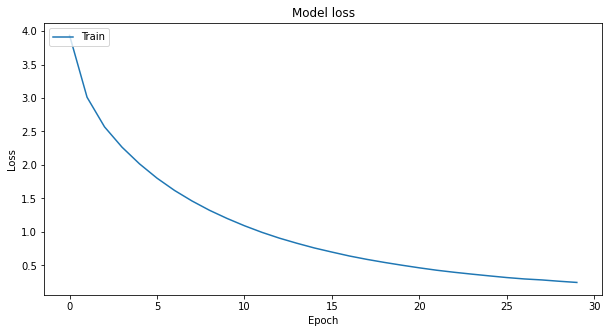

In [ ]:
# Plot training & validation iou_score values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
model.save('final_attention_subject_upd')

INFO:tensorflow:Assets written to: final_attention_subject_upd/assets


INFO:tensorflow:Assets written to: final_attention_subject_upd/assets


In [ ]:
loaded_model_att = tf.keras.models.load_model('final_attention_subject_upd',custom_objects={'custom_lossfunction':custom_lossfunction})

In [ ]:
loaded_model_att.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
encoder_1 (Encoder)             ((None, 16, 512), (N 15132924    input_4[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 5)]          0                                            
______________________________________________________________________________________________

In [ ]:
def predict(input_sentence,model):
  
  '''
  Given an input sentence, we need to predict the next words.
  Tokenize and pad the input sentence,
  Pass it to encoder's embedding layer and its output to encoder's LSTM layer.
  Pass its final states hidden and cell states as inputs to decoder's LSTM
  Pass the encoder's output of all time steps as input to one step decoder to calculate context vector using attention weights
  Append that context vector with decoder's current step to predict the next time steps output.
  Before that, initialize <start> word and pass it to decoders embedding layer and then to LSTM layer,
  We run a loop till we get <end> word.
  We give predicted word at decoder's current step as input to its next step.
  '''

  encoder_test_tokens = tokenizer_encoder.texts_to_sequences([input_sentence])
  padded_encoder_input = pad_sequences(encoder_test_tokens, maxlen=16, dtype='float32', padding='post')
  encoder = model.layers[2]
  encoder_op, enc_h, enc_c = encoder(padded_encoder_input)
  decoder = model.layers[4]
  index_of_start = np.array(tokenizer_decoder.word_index['<start>']).reshape(1,1).astype('float32')
  pred=0
  sentence = []
  attention_weights=[]
  # att_wgts = tf.TensorArray(dtype=tf.float32, dynamic_size=True,size=0)
  while pred!=tokenizer_decoder.word_index['<end>']:
    predicted_out,enc_h, enc_c,attention,context_vector = decoder.onestepdecoder(index_of_start,encoder_op, enc_h, enc_c)
    pred = np.argmax(predicted_out) 
    word = [k for k in tokenizer_decoder.word_index if tokenizer_decoder.word_index[k]==(pred)][0]
    sentence.append(word)
    index_of_start = np.array(pred).reshape(1,1).astype('float32')

  return ' '.join(sentence[:-1])

In [ ]:
import numpy as np
sample = new_data.sample(100000,random_state=42)
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
incorrect_predictions_att=[]
for i in tqdm(sample.index):
  predicted = predict(new_data.loc[i]['input'],loaded_model_att)
  predicted_sent = predicted.split()
  original = [x for x in new_data.loc[i]['decoder_input'].split() if x!='<start>']
  if bleu.sentence_bleu([original],predicted_sent)<0.2:
    incorrect_predictions_att.append((new_data.loc[i]['input'],' '.join(original),predicted))


100%|██████████| 100000/100000 [1:23:01<00:00, 20.07it/s]


In [ ]:
for i in range(20,40):
  print(incorrect_predictions_att[i][0],"_",incorrect_predictions_att[i][1],'_',incorrect_predictions_att[i][2])

hard lessons from california if you have any _ questions do not _ thing off the
congrats i met bro _ wn at a _ ker last week
charts i am for _ wading some charts _ ward on the
cuts by the ciso please refer to transalta _ tag numbers w _ an thomas northern
counterparties western gas resources anyone _ please let me _ ng it is
behavior update i did not assign _ her a consequence _ ed to anything
delano for sunday monday when you contact the control room please _ only speak in _ ed our settlements
baby shower just kidding hope you _ all are doing _ can not find
nobody scheduled on day shift please let me know _ what you would _ when these are
sorry sean just changed this _ deal from _ ed to sell
omnibus revisions we may come _ up with more omnibus _ back out as to
l visa documents my address is as follows barry _ tycholiz c o enron _ ton mark e
island ecn inc. confidentiality agreement please find attached a copy _ of the _ for his
undeliverable var rate sheet o enron ou _ na cn recipient

In [ ]:
import pickle
outfile = open('incorrect_preds_att.pkl','wb')
pickle.dump(incorrect_predictions_att,outfile)
outfile.close()

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
sample = new_data.sample(1000)
import nltk.translate.bleu_score as bleu

blue_scores=[]
for n,i in enumerate(sample.index):
  input_sentence = sample.loc[i]['input']
  predicted = predict(input_sentence,loaded_model_att)
  predicted = predicted.split()
  original = [x for x in sample.loc[i]['decoder_input'].split() if x!='<start>']
  if n in range(50):
    print('-- ip:',new_data.loc[i]['input'],'-- prd: ' ,' '.join(predicted))
    print('-- ip:',new_data.loc[i]['input'],'-- orgnl: ' ,' '.join(original),'\n')

  blue_scores.append(bleu.sentence_bleu([original],predicted))

np.mean(blue_scores)

-- ip: materials for scott mcnealy does that work for you best dasovi -- prd:  ch enron corp
-- ip: materials for scott mcnealy does that work for you best dasovi -- orgnl:  ch enron corp 

-- ip: action required time entry due if you have log prob -- prd:  lems call the
-- ip: action required time entry due if you have log prob -- orgnl:  lems call the 

-- ip: loss of a leader i want to see this -- prd:  but we
-- ip: loss of a leader i want to see this -- orgnl:  house you 

-- ip: erv please shout with questio -- prd:  ns or concerns
-- ip: erv please shout with questio -- orgnl:  ns or concerns 

-- ip: salmon energy records delta power do one of you gentlemen have this we are getting -- prd:  them for signature
-- ip: salmon energy records delta power do one of you gentlemen have this we are getting -- orgnl:  close to closing 

-- ip: fw comments on footnotes sent from my wirele -- prd:  ss handheld www
-- ip: fw comments on footnotes sent from my wirele -- orgnl:  ss handheld w

0.7284194247955131

In [ ]:
import copy
def beam_predict(input_sentence,model):

  '''
  Follow the same steps as normal predict function till generating encoder's output.
  After that we use beam search logic.
  Generate top three predictions by passing <start> as input.
  Pass those 3 words as input to one step decoder along with encoder output and generate top three words for each word.
  Thus we have total 9 combinatios. We filter out top 3 with high probabilities and 
  pass the last word of that combination to the next step of one step decoder and repeat the process until we encounter <end> in three sentences
  '''
  
  encoder_test_tokens = tokenizer_encoder.texts_to_sequences([input_sentence])
  padded_encoder_input = pad_sequences(encoder_test_tokens, maxlen=16, dtype='float32', padding='post')
  encoder = model.layers[2]
  encoder_op, enc_h, enc_c = encoder(padded_encoder_input)
  decoder = model.layers[4]
  index_of_start = np.array(tokenizer_decoder.word_index['<start>']).reshape(1,1).astype('float32')
  predicted_out,enc_h, enc_c,attention,context_vector = decoder.onestepdecoder(index_of_start,encoder_op, enc_h, enc_c)
  state_h, state_c = enc_h,enc_c
  states = (state_h, state_c)
  toppred = np.argsort(predicted_out[0])[-3:][::-1]
  probs = np.sort(predicted_out[0])[-3:][::-1]
  words = []
  for pred in toppred:
    word = [k for k in tokenizer_decoder.word_index if tokenizer_decoder.word_index[k]==pred][0]
    words.append(word)
  semi_final = [[probs[0],[toppred[0]],[words[0]],states],[probs[1],[toppred[1]],[words[1]],states],[probs[2],[toppred[2]],[words[2]],states]]
  finished_sentences = 0
  final = []
  while (True):
    temp = []
    for i in range(len(semi_final)):
      # dec_emb= decoder.embedding(semi_final[i][1][-1].reshape(1,1))
      predicted_out,state_h, state_c,attention,context_vector = decoder.onestepdecoder(semi_final[i][1][-1].reshape(1,1).astype('float32'),
                                                                                       encoder_op, semi_final[i][-1][0], semi_final[i][-1][1])
      toppred = np.argsort(predicted_out[0])[-len(semi_final):][::-1]
      probs = np.sort(predicted_out[0])[-len(semi_final):][::-1]
      states= (state_h, state_c)
      for j in range(len(toppred)):
        word = [k for k in tokenizer_decoder.word_index if tokenizer_decoder.word_index[k]==toppred[j]][0]
        #temp[str(i)+','+str(j)] = (semi_final[i][0] * probs[j],toppred[j],semi_final[i][2].append(word),states)
        words = copy.deepcopy(semi_final[i][2])
        words.append(word)
        temp.append([semi_final[i][0] * probs[j],[toppred[j]],words,states])
    temp = sorted(temp,key = lambda x:x[0],reverse=True)[:len(semi_final)]
    ids_to_be_removed = []
    for id,k in enumerate(temp):
      if k[2][-1] == '<end>':
        final.append((k[0],' '.join(k[2][:-1])))
        finished_sentences+=1
        ids_to_be_removed.append(id)
    for id in ids_to_be_removed:
      temp[id] = 0
    temp = [i for i in temp if i!=0]
    semi_final=temp
    if finished_sentences == 3:
      break

  return final

In [ ]:
sample = new_data.sample(15)
blue_scores=[]
for i in sample.index:
  predicted = beam_predict(new_data.loc[i]['input'],loaded_model_att)
  original = [x for x in new_data.loc[i]['decoder_input'].split() if x!='<start>']
  print('-- ip:',new_data.loc[i]['input'],'-- prd: ' ,[x[1] for x in predicted])
  print('-- ip:',new_data.loc[i]['input'],'-- orgnl: ' ,' '.join(original),'\n')


-- ip: executive reports viewer i received an email morni -- prd:  ['ng regarding the', 'ng and represent', 'ng regarding this']
-- ip: executive reports viewer i received an email morni -- orgnl:  ng regarding the 

-- ip: com ed lois i will bring them up for -- prd:  ['initialling once i', 'initialling once we', 'initialling once that']
-- ip: com ed lois i will bring them up for -- orgnl:  initialling once i recieve 

-- ip: conference call gas curtailment and do we have a -- prd:  ['look at it', 'look into it', 'look at the']
-- ip: conference call gas curtailment and do we have a -- orgnl:  call in number 

-- ip: hr issues jae black east trad -- prd:  ['ing assistant to', 'ing support assistant', 'ing assistant to kevin']
-- ip: hr issues jae black east trad -- orgnl:  ing assistant to 

-- ip: stanford mckinsey case study globe talking with skilling cindy vin -- prd:  ['ce kaminski p', 'ce kaminski vince', 'ce kaminski http']
-- ip: stanford mckinsey case study globe talking wit

#Analysis of incorrect predictions from both models

In [6]:
import pickle
infile = open('incorrect_preds.pkl','rb')
incorrect_predictions = pickle.load(infile)
infile.close()

In [21]:
import random
sampless = random.sample(range(len(incorrect_predictions)), 25)

In [22]:
for i in sampless:
  print(incorrect_predictions[i][0],"_",incorrect_predictions[i][1],'_',incorrect_predictions[i][2])

legal agreement status from aneela i realize cheryl has been working on _ some of this _ today is cell
project granite update thanks mitch paul kaufman ect _ pm to _ ric fax
dow jones article re eei i will call _ mark golden to respond _ ing new counterparties
ut update please let me know by friday if you _ plan to _ have any
hey you are won _ derful person by _ dering how all
wellhead meeting ed mcmichael would _ like to have a _ ing for another
therefore you will soon _ have the option _ er for or
structured sales to ca chris thanks a lot for the info and _ the help _ rew energy manager
aol messenger.. ok now what _ i signed up downloaded _ all now is now
green card permanent resident alien best regards bobbi international human resources telephone _ work space eb _ phone fax pager
ca iso newsflash on dg i spoke with the ca _ iso attorney _ ence in europe
puc public participation hearing to participate you must arrive early and _ sign in to _ rea for further
fw super bowl you were al

In [14]:
infile = open('incorrect_preds_att.pkl','rb')
incorrect_predictions_att = pickle.load(infile)
infile.close()

In [19]:
import random
sampless_att = random.sample(range(len(incorrect_predictions_att)), 25)

In [20]:
for i in sampless_att:
  print(incorrect_predictions_att[i][0],"_",incorrect_predictions_att[i][1],'_',incorrect_predictions_att[i][2])

congratulations sally i just read the _ email announcing _ re from origination
land option new york correct on the edgecombe _ north carolina thing _ ent z basis
marking chairs we will let you know when this will _ take place _ not be processed
weather review the weather sho _ uld be cash _ ws those authority
please please please it is a potato peeler _ my favorite _ one for the
wellhead deals changed daren o neal the attached spreadsheet represents _ deal volumes changed _ the gas valuation
fw top imbalances for october bcf long to the pipe _ position on _ line for the
ipams legal legislative and regulatory committee will _ meet wednesday november _ iams through monday
legal support for sao paulo do you still _ want to do it _ have any thoughts or
phone for steve sorry the on his _ printed itinerary was _ age look at
share information about yourself create _ your own _ ed at http
dept. of justice interview eol haedicke said you knew about _ this and _ one is reference
liz are dia _ mo

From the examples above from both normal encoder decoder model and attention model, we can see multiple cases,


Input | Original | Predicted

##Prediction is better than the original

  - can you send me an _ enail with _ email confirming

  - we had to leave _ the severance date _ a few hours

  - new deal check out model can you schedule minutes after _ trading on _ noon to

  - i also need the _ delivery points for _ se up to

- possible candidate please forward to _ appropriate parties if there _ anyone soon





## Since the sentence was long, model wasn't able to learn properly

  - eol hold list for global the counterparties replacing these entities are still being reviewed by credit _ legal and contracts _ on enron corp

  - hpl meter hughes cmp currently these volumes are being recorded to _ the hpl strangers _ gas counterparties

- no management committee meeting on afternoon there will not be a meeting _ on tuesday following _ ing the nov


## Prediction is also meaningful as original but both doesn't match

  - hey matt i gave her my digits and _ told her to call _ my number is

  - dabhol steve please look at the _ link below _ se comments back

  - i really meant to call you back _ but could not _ to work on

  - how are you feeling i _ hope well _ am coming

  - share information about yourself create _ your own _ ed at http

  - do you yahoo find a _ job post _ great connection




##The input or original is rare to occur i.e. so specific

  - tagg exchange users the users i would start with _ are todd warwick frank _ out a little point

  - mobil beaumont rebecca i spoke with brian nichols about the _ august preliminary _ online matter

- pg e filed testimony and i will forward our protest _ and iep _ ing this morning

- ena vng contract leg mdq z i might be looking _ in the wrong _ ing with this

- what are the klan is tow _ ard asians lc _ er at el

- analyst and associate dinner august no later than close _ of business monday _ ing the hour



##Some examples look easy but model didn't predict well

  - i think you said tomorrow at pm would _ work for _ ing to turn

  - new email id therefore please update _ your address books to _ ation on my
  
  - real option conference i would like to attend _ this conference _ ing the above

- invoices i was planning _ on calling you after _ ing for jeff

- i will try _ to find out more _ ing you and


